In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [2]:
data1=pd.read_csv("D:\sih\load forecasting.csv")
df = pd.DataFrame(data = data1)

In [3]:
df.set_index('Date_Time',inplace=True)

In [4]:
df.head()

,Days,hour,Relative Humidity in %,Temperature,Radiation value in MJ/m^2,Wind Direction,Wind speed in kmph,Demand,Kerala Holidays
Date_Time,,,,,,,,,
1/1/2017 0:00,1,1,88.0,14.664,0.0,9.0,4.0,342.665714,True
1/1/2017 1:00,1,2,NaN,14.052,0.0,NaN,NaN,319.832857,True
1/1/2017 2:00,1,3,NaN,13.581,0.0,NaN,NaN,308.755714,True
1/1/2017 3:00,1,4,78.0,13.197,0.0,14.0,4.0,299.235714,True
1/1/2017 4:00,1,5,NaN,12.750,0.0,NaN,NaN,294.884286,True


In [5]:
features = df.iloc[:,:-1].values

In [6]:
features

array([[1.00000000e+00, 1.00000000e+00, 8.80000000e+01, ...,
        9.00000000e+00, 4.00000000e+00, 3.42665714e+02],
       [1.00000000e+00, 2.00000000e+00,            nan, ...,
                   nan,            nan, 3.19832857e+02],
       [1.00000000e+00, 3.00000000e+00,            nan, ...,
                   nan,            nan, 3.08755714e+02],
       ...,
       [1.09500000e+03, 2.20000000e+01, 9.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 5.07987143e+02],
       [1.09500000e+03, 2.30000000e+01,            nan, ...,
        0.00000000e+00, 0.00000000e+00, 4.87674286e+02],
       [1.09500000e+03, 2.40000000e+01,            nan, ...,
        0.00000000e+00, 0.00000000e+00, 4.64871429e+02]])

In [7]:
df.isnull().sum()/len(df)

Days                         0.000000
hour                         0.000000
Relative Humidity in %       0.669863
Temperature                  0.000000
Radiation value in MJ/m^2    0.000000
Wind Direction               0.473364
Wind speed in kmph           0.473554
Demand                       0.000000
Kerala Holidays              0.000000
dtype: float64

In [8]:
#so many missing values.hence droping out those columns.
df.drop(('Relative Humidity in %') ,axis=1, inplace=True)
df.drop(('Wind speed in kmph'), axis=1, inplace=True)
df.drop(('Wind Direction'), axis=1, inplace=True)

In [9]:
df.head()

,Days,hour,Temperature,Radiation value in MJ/m^2,Demand,Kerala Holidays
Date_Time,,,,,,
1/1/2017 0:00,1,1,14.664,0.0,342.665714,True
1/1/2017 1:00,1,2,14.052,0.0,319.832857,True
1/1/2017 2:00,1,3,13.581,0.0,308.755714,True
1/1/2017 3:00,1,4,13.197,0.0,299.235714,True
1/1/2017 4:00,1,5,12.750,0.0,294.884286,True


In [10]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [13]:
target_names = ['Demand']

In [14]:
df_targets = df[target_names].shift(-shift_steps)

In [16]:
x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (26256, 6)


In [17]:
y_data = df_targets.values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)


<class 'numpy.ndarray'>
Shape: (26256, 1)


In [18]:
num_data = len(x_data)
num_data

26256

In [19]:
train_split = 0.9

In [20]:
num_train = int(train_split * num_data)
num_train

23630

In [21]:
num_test = num_data - num_train
num_test

2626

In [22]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

26256

In [23]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

26256

In [24]:
num_x_signals = x_data.shape[1]
num_x_signals

6

In [25]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [26]:
x_scaler = MinMaxScaler()

In [27]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [28]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [29]:
x_test_scaled = x_scaler.transform(x_test)

In [30]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [31]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(23630, 6)
(23630, 1)


In [32]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [43]:
batch_size = 250
sequence_length = 24
sequence_length

168

In [44]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [45]:
x_batch, y_batch = next(generator)

In [46]:
print(x_batch.shape)
print(y_batch.shape)

(250, 168, 6)
(250, 168, 1)


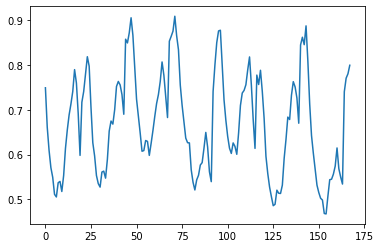

In [48]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [49]:

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [50]:
model = Sequential()

In [51]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [52]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [53]:

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [54]:
optimizer = RMSprop(lr=1e-3)

In [55]:
model.compile(loss='mse', optimizer=optimizer)


In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         798720    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 799,233
Trainable params: 799,233
Non-trainable params: 0
_________________________________________________________________


In [57]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [58]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [59]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [60]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [61]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [62]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0096
Epoch 00001: val_loss improved from inf to 0.00622, saving model to 23_checkpoint.keras
100/100 [==============================] - 219s 2s/step - loss: 0.0096 - val_loss: 0.0062 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0057
Epoch 00002: val_loss improved from 0.00622 to 0.00411, saving model to 23_checkpoint.keras
100/100 [==============================] - 226s 2s/step - loss: 0.0057 - val_loss: 0.0041 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0046
Epoch 00003: val_loss improved from 0.00411 to 0.00281, saving model to 23_checkpoint.keras
100/100 [==============================] - 231s 2s/step - loss: 0.0046 - val_loss: 0.0028 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0040
Epoch 00004: val_loss improved from 0.00281 to 0.00263, saving model to 23_checkpoint.keras
100/100 [==========

In [63]:

try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [64]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 2ms/step - loss: 0.0022


In [65]:
print("loss (test-set):", result)

loss (test-set): 0.0021726738195866346


In [66]:
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [69]:

def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

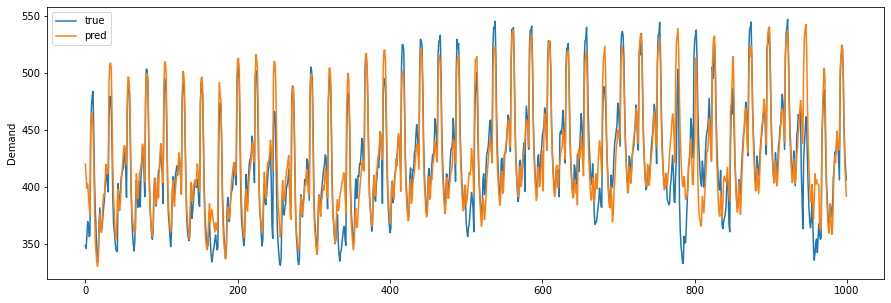

In [84]:
plot_comparison(start_idx=1500, length=1000, train=True)
#predictions on training set

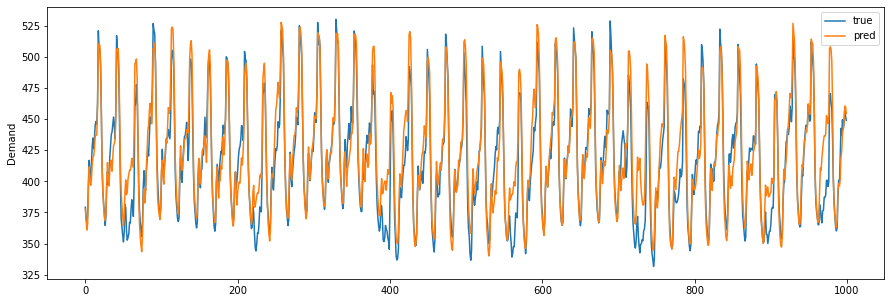

In [83]:
plot_comparison(start_idx=1500, length=1000, train=False)
#predictions on testing set

In [85]:
model.save("demand.h5")


In [87]:
df

,Days,hour,Temperature,Radiation value in MJ/m^2,Demand,Kerala Holidays
Date_Time,,,,,,
1/1/2017 0:00,1,1,14.664,0.0,342.665714,True
1/1/2017 1:00,1,2,14.052,0.0,319.832857,True
1/1/2017 2:00,1,3,13.581,0.0,308.755714,True
1/1/2017 3:00,1,4,13.197,0.0,299.235714,True
1/1/2017 4:00,1,5,12.750,0.0,294.884286,True
...,...,...,...,...,...,...
12/31/2019 19:00,1095,20,5.878,0.0,534.322857,False
12/31/2019 20:00,1095,21,5.850,0.0,516.645714,False
12/31/2019 21:00,1095,22,5.745,0.0,507.987143,False


In [88]:
x_scaler = MinMaxScaler()

In [90]:
df_scaled = x_scaler.fit_transform(df)

In [91]:
df_resclaed=np.expand_dims(df_scaled,axis=0)

In [106]:
c=model.predict(df_resclaed)

In [107]:
demand = y_scaler.inverse_transform(c[0])

In [108]:
demand

array([[348.76138],
       [323.21545],
       [319.88303],
       ...,
       [519.5603 ],
       [499.29517],
       [474.4331 ]], dtype=float32)

In [2]:
import xlsxwriter
load= xlsxwriter.Workbook('weather.xlsx')

# Workbook is created 
sheet=load.add_worksheet()
  
# add_sheet is used to create sheet. 

In [ ]:
for i in range(24):
    c=demand[i]
    sheet.write(i, 0, i)
    sheet.write(i,1,c)
load.close()